# How to rediscover the Higgs boson yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

The datasets used in this notebook have already been filtered to include at least 2 photons per event, so that processing is quicker.

<CENTER><img src="Hyy_feynman.pdf" style="width:40%"></CENTER>

## First time setup
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close jupyter and re-open on the same computer, you won't need to run this first cell again.

If you re-open on binder, you will need to run this cell again.

If you run into a problem of "uproot not being available", Kernel -> Restart & Run All

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy pandas uproot matplotlib lmfit --user

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [41]:
import uproot
import pandas as pd
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import PolynomialModel, GaussianModel
from matplotlib.ticker import MultipleLocator,LogLocator,LogFormatterSciNotation # for minor ticks

In [42]:
lumi = 547 # pb-1

tuple_path = "Photon_Input/Data/"

In [43]:
samples = {

    'data': {
        'list' : ['data_A']
    },

}

In [44]:
def get_data_from_files():

    data = {}
    
    for s in samples:
        print(s+':')
        frames = []
        for val in samples[s]['list']:
            fileString = tuple_path+val+".GamGam.root"
            if fileString != "":
                temp = read_file(fileString,val)
                frames.append(temp)
            else:
                print("Error: "+val+" not found!")
        data[s] = pd.concat(frames)

    return data

In [45]:
def calc_myy(photon_pt,photon_eta,photon_phi):
    myy = 2*photon_pt[0]*photon_pt[1]
    cosh = math.cosh(photon_eta[0]-photon_eta[1])
    cos = math.cos(photon_phi[0]-photon_phi[1])
    myy *= ( cosh - cos )
    return math.sqrt(myy)/1000

## Changing an already uncommented cut

If you change a cut: Cell -> Run All Below

If you uncomment a cut here, you also need to uncomment the corresponding cut in the cell above.

In [46]:
# Cut on number of photons
# paper: "The data used in this channel are selected using a diphoton trigger, which requires two clusters"
def cut_photon_n (photon_n):
# want to discard any events where photon_n does not equal 2
    # exclamation mark (!) means "not"
    # so != means "not equal to"
    return photon_n != 2

# Cut on pseudorapidity outside the fiducial region
# paper: "Photon candidates are reconstructed in the fiducial region |η| < 2.37"
def cut_photon_eta_fiducial(photon_eta):
# want to discard any events where modulus of photon_eta > 2.37
    return photon_eta[0] > 2.37 or photon_eta[1] > 2.37 or photon_eta[0] < -2.37 or photon_eta[1] < -2.37

# Cut on pseudorapidity in barrel/end-cap transition region
# paper: "excluding the calorimeter barrel/end-cap transition region 1.37 <􏰈 |η| < 1.52"
def cut_photon_eta_transition(photon_eta):
# want to discard events where modulus of photon_eta between 1.37 and 1.52
    if photon_eta[0] < 1.52 and photon_eta[0] > 1.37: return True
    elif photon_eta[1] < 1.52 and photon_eta[1] > 1.37: return True
    elif photon_eta[0] > -1.52 and photon_eta[0] < -1.37: return True
    elif photon_eta[1] < -1.37 and photon_eta[1] > -1.52: return True
    else: return False
    
# Cut on Transverse momentum
# paper: "The leading (sub-leading) photon candidate is required to have ET > 40 GeV (30 GeV)"
def cut_photon_pt(photon_pt):
# want to discard any events where photon_pt[0] < 40000 MeV or photon_pt[1] < 30000 MeV
    # first lepton is [0], 2nd lepton is [1] etc
    return photon_pt[0] < 40000 or photon_pt[1] < 30000

# Cut on photon reconstruction
# paper: "Photon candidates are required to pass identification criteria"
def cut_photon_reconstruction(photon_isTightID):
# want to discard events where it is false for one or both photons
    return photon_isTightID[0] == False or photon_isTightID[1] == False

# Cut on energy isolation
# paper: "Photon candidates are required to have an isolation transverse energy of less than 4 GeV"
def cut_isolation_et(photon_etcone20):
# want to discard events where isolation eT > 4000 MeV
    return photon_etcone20[0] > 4000 or photon_etcone20[1] > 4000
    
# Cut on reconstructed invariant mass lower limit
# paper: "in the diphoton invariant mass range between 100 GeV and 160 GeV"
def cut_mass_lower(myy):
# want to discard minimum invariant reconstructed mass < 100 GeV
    return myy < 100

# Cut on reconstructed invariant mass upper limit
# paper: "in the diphoton invariant mass range between 100 GeV and 160 GeV"
def cut_mass_upper(myy):
# want to discard maximum invariant reconstructed mass > 160 GeV
    return myy > 160

## Uncommenting a new cut 

If you add a cut: Cell -> Run All Below

In [47]:
def read_file(path,sample):
    start = time.time()
    print("\tProcessing: "+sample)
    mc = uproot.open(path)["mini"]
    data = mc.pandas.df(["photon_n","photon_trigMatched","photon_pt","photon_eta","photon_phi","photon_isTightID",
                         "photon_etcone20"], flatten=False)

    nIn = len(data.index)
       
    # Calculate reconstructed diphoton invariant mass
    data['myy'] = np.vectorize(calc_myy)(data.photon_pt,data.photon_eta,data.photon_phi)
    
    # Cut on number of photons
    fail = data[ np.vectorize(cut_photon_n)(data.photon_n)].index
    data.drop(fail, inplace=True)
    
    # Cut on pseudorapidity outside fiducial region
    fail = data[ np.vectorize(cut_photon_eta_fiducial)(data.photon_eta)].index
    data.drop(fail, inplace=True)
    
    # Cut on pseudorapidity inside barrel/end-cap transition region
    fail = data[ np.vectorize(cut_photon_eta_transition)(data.photon_eta)].index
    data.drop(fail, inplace=True)
    
    # Cut on transverse momentum of the photons
    fail = data[ np.vectorize(cut_photon_pt)(data.photon_pt)].index
    data.drop(fail, inplace=True)
    
    # Cut on photon reconstruction
    fail = data[ np.vectorize(cut_photon_reconstruction)(data.photon_isTightID)].index
    data.drop(fail, inplace=True)
    
    # Cut on energy isolation
    fail = data[ np.vectorize(cut_isolation_et)(data.photon_etcone20)].index
    data.drop(fail, inplace=True)
    
    # Cut on lower limit of reconstructed invariant mass
    fail = data[ np.vectorize(cut_mass_lower)(data.myy)].index
    data.drop(fail, inplace=True)
    
    # Cut on upper limit of reconsructed invariant mass
    fail = data[ np.vectorize(cut_mass_upper)(data.myy)].index
    data.drop(fail, inplace=True)
    
    # dataframe contents can be printed at any stage like this
    #print(data)
    
    # dataframe column can be printed at any stage like this
    #print(data['photon_pt'])
    
    # dataframe columns can be printed at any stage like this
    #print(data[['photon_pt','photon_eta']])
    
    nOut = len(data.index)

    elapsed = time.time() - start
    print("\t\tTime taken: "+str(elapsed)+", nIn: "+str(nIn)+", nOut: "+str(nOut))
    
    return data

In [50]:
def plot_data(data):
    
    bin_width = 2
    num_bins = 30
    xrange_min = 100
    bins = [xrange_min + x*bin_width for x in range(num_bins+1) ]
    data_x = [xrange_min+bin_width/2 + x*bin_width for x in range(num_bins) ]

    data_myy,_ = np.histogram(data['data'].myy.values, bins=bins)
    data_myy_errors = np.sqrt(data_myy)
       
    top = np.amax(data_myy)*1.1

    # data fit
    polynomial_mod = PolynomialModel(4)
    gaussian_mod = GaussianModel()
    data_x_array = np.asarray(data_x)
    pars = polynomial_mod.guess(data_myy, x=data_x_array, c0=data_myy.max(), c1=0, c2=0, c3=0, c4=0)
    pars += gaussian_mod.guess(data_myy, x=data_x_array, amplitude=91.7, center=125., sigma=2.4)
    model = polynomial_mod + gaussian_mod
    out = model.fit(data_myy, pars, x=data_x_array, weights=1/data_myy_errors)
    
    # background part of fit
    params_dict = out.params.valuesdict()
    c0 = params_dict['c0']
    c1 = params_dict['c1']
    c2 = params_dict['c2']
    c3 = params_dict['c3']
    c4 = params_dict['c4']
    background = c0 + c1*data_x_array + c2*data_x_array**2 + c3*data_x_array**3 + c4*data_x_array**4
    
    plt.axes([0.1,0.3,0.85,0.65]) #(left, bottom, width, height)
    main_axes = plt.gca()
    main_axes.errorbar( x=data_x, y=data_myy, yerr=data_myy_errors, fmt='ko', label='Data')
    main_axes.plot(data_x, out.best_fit, '-r', label='Sig+Bkg Fit')
    main_axes.plot(data_x, background, '--r', label='Bkg (4th order polynomial)')
    
    # Create new legend handles but use the colors from the existing ones 
    handles, labels = main_axes.get_legend_handles_labels()
    
    # specify order within legend
    handles = [handles[labels.index('Data')],handles[labels.index('Sig+Bkg Fit')],
               handles[labels.index('Bkg (4th order polynomial)')]]
    labels = ['Data','Sig+Bkg Fit ($m_H=125$ GeV)','Bkg (4th order polynomial)']
                                                                                                                                                                      
    main_axes.set_ylim(bottom=0,top=top)
    main_axes.yaxis.set_minor_locator(MultipleLocator(100))
    main_axes.set_xlim(left=xrange_min,right=bins[-1])
    #main_axes.set_yticks([1000,2000,3000,4000,5000,6000,7000,8000,9000])
    main_axes.xaxis.set_minor_locator(MultipleLocator(2))
    main_axes.tick_params(which='both',direction='in',top=True,labeltop=False,labelbottom=False,right=True,labelright=False)
        
    main_axes.set_ylabel(r'Events / '+str(bin_width)+r' GeV',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)

    lumi_used = str(lumi/1000)
    plt.text(0.2,0.97,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="top",family='sans-serif',transform=main_axes.transAxes,fontsize=13)
    plt.text(0.2,0.90,'for education only',ha="left",va="top",family='sans-serif',transform=main_axes.transAxes,style='italic',fontsize=8)
    plt.text(0.2,0.86,r'$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=$'+lumi_used+r'$\,\mathrm{fb}^{-1}$',ha="left",va="top",family='sans-serif',transform=main_axes.transAxes)
    plt.text(0.2,0.79,r'$H \rightarrow \gamma\gamma$',ha="left",va="top",family='sans-serif',transform=main_axes.transAxes)

    main_axes.legend(handles=handles, labels=labels, frameon=False, loc='lower left')
    
    
    # data - background fit plot
    signal_myy = data_myy - background
    plt.axes([0.1,0.1,0.85,0.2])
    ratio_axes = plt.gca()
    ratio_axes.errorbar( x=data_x, y=signal_myy, yerr=data_myy_errors, fmt='ko')
    ratio_axes.plot(data_x, out.best_fit-background, '-r')
    ratio_axes.plot(data_x, background-background, '--r')                                                                                                                                                                     
    ratio_axes.set_ylim(bottom=-signal_myy.max()-data_myy_errors.max(),top=signal_myy.max()+data_myy_errors.max())
    ratio_axes.set_xlim(left=xrange_min,right=bins[-1])
    #ratio_axes.set_yticks([-200,-100,0,100,200])
    ratio_axes.yaxis.set_minor_locator(MultipleLocator(10))
    ratio_axes.xaxis.set_minor_locator(MultipleLocator(2))
    ratio_axes.set_ylabel(r'Events-Bkg',fontname='sans-serif',fontsize=11)
    ratio_axes.set_xlabel(r'$m_{\gamma\gamma}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)
    ratio_axes.yaxis.set_label_coords(-0.09,0.5)
    ratio_axes.tick_params(which='both',direction='in',top=True,labeltop=False,right=True,labelright=False)
    
    plt.savefig("plot.pdf")
    
    print('chi^2 = '+str(out.chisqr))
    print('gaussian centre = '+str(params_dict['center']))
    print('gaussian sigma = '+str(params_dict['sigma']))
    
    return

data:
	Processing: data_A
		Time taken: 38.11190104484558, nIn: 430344, nOut: 8493
chi^2 = 11.572200352992416
gaussian centre = 125.95223323415038
gaussian sigma = 0.4231676133281086
Time taken: 39.78013300895691


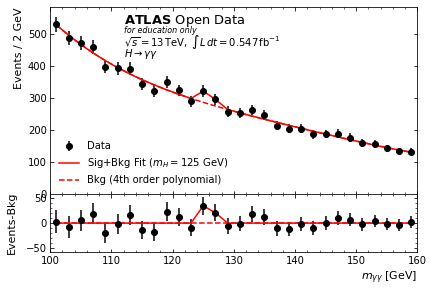

In [51]:
if __name__=="__main__":
    start = time.time()
    data = get_data_from_files()
    plot_data(data)
    elapsed = time.time() - start
    print("Time taken: "+str(elapsed))